In [1]:
using DelimitedFiles
using Plots
using DifferentialEquations
using ProgressBars
using Statistics
using PyCall
include("./model_1R.jl");
include("./model_RI.jl");
include("./model_RI_noload.jl");
include("./model_1R_coupled.jl");
include("./model_1RI_full.jl");
include("./solve.jl");
include("./plotmodel.jl");

In [2]:
# Global settings
Plots.pyplot()
PATH_OUT = "./output/"
fntsm = Plots.font("sans-serif", pointsize=round(14.0))
fntlg = Plots.font("sans-serif", pointsize=round(18.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)

TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

idx_R=1;
idx_dT=2;
idx_dG=3;
idx_mT=4;
idx_mG=5;
idx_pT=6;
idx_pG=7;

In [3]:
# Set initial conditions

R0=100.0;
dT0=0.01;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;

u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

In [4]:
# Solve
FILE_OUT_t = "t.csv"
FILE_OUT_U = "U.csv"
FILE_OUT_Dt = "Dt.csv"
FILE_OUT_DU = "DU.csv"

#TSAVE = 0.0:20.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");

writedlm(string(PATH_OUT,FILE_OUT_t),  solU.t, ',')
writedlm(string(PATH_OUT,FILE_OUT_U),  solU.u, ',')
writedlm(string(PATH_OUT,FILE_OUT_Dt),  solDU.t, ',')
writedlm(string(PATH_OUT,FILE_OUT_DU),  solDU.saveval, ',')

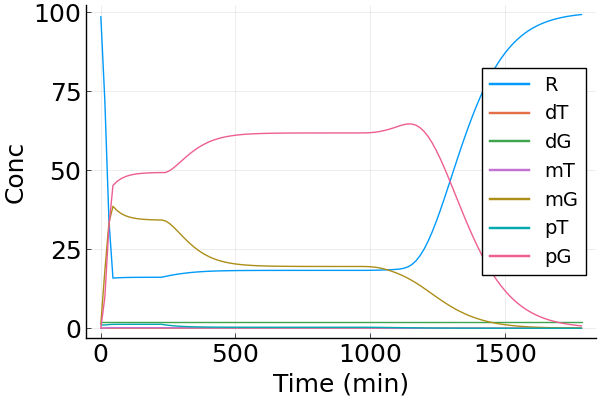

In [5]:
plotmodel(solU,"U")

# 1. T7 DNA titration - time series, ratio curve

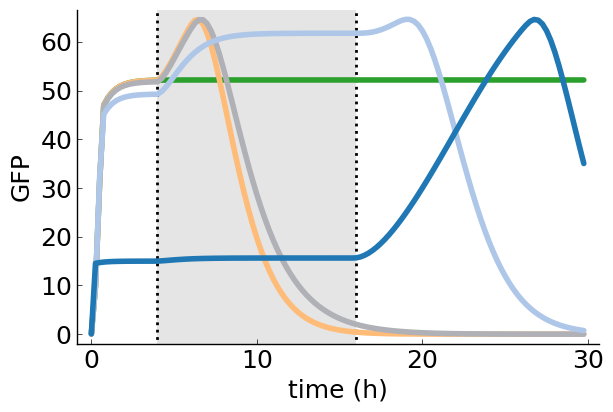

In [19]:
# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

96.7%┣█████████████████████████████████████████▋ ┫ 29/30 [00:04<00:00, 7.1 it/s]

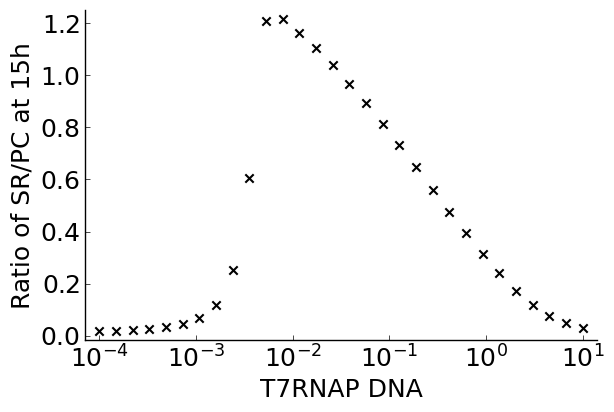

100.0%┣██████████████████████████████████████████┫ 30/30 [00:04<00:00, 7.1 it/s]


In [21]:
# 1.2 Ratio curve
CONCS = exp10.(range(-4, stop=1, length=30))
ratio_SRPC = []
FN="ratio_GFP_1R.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

## 1.1 Elucidation of model: concentrations

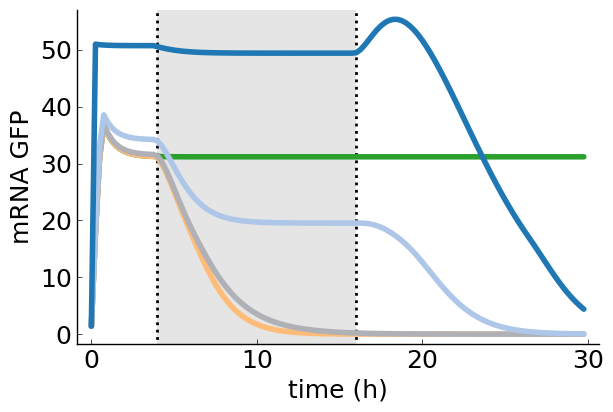

In [22]:
# 1A mRNA GFP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p2 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFPm.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
mGPC = [datum for subarr in solU.u for datum in subarr[idx_mG]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
mGNC = [datum for subarr in solU.u for datum in subarr[idx_mG]];

plot!(t,mGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="mRNA GFP",lw=4);
plot!(t,mGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    mG = [datum for subarr in solU.u for datum in subarr[idx_mG]];
    plot!(t,mG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p2 # Show plot
savefig(PATH_OUT*FN)

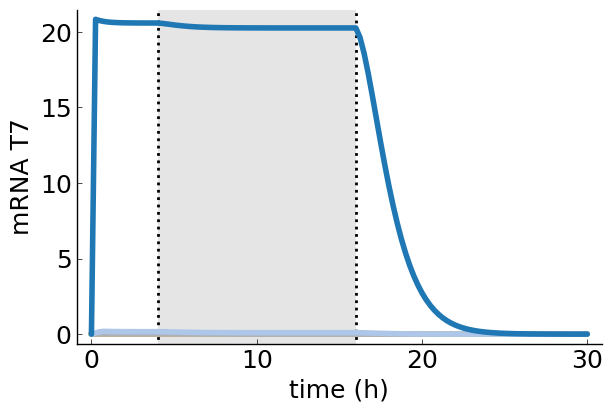

In [23]:
# 1A mRNA T7
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p3 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_T7m.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX)
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
mTPC = [datum for subarr in solU.u for datum in subarr[idx_mT]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
mTNC = [datum for subarr in solU.u for datum in subarr[idx_mT]];

plot!(t,mTPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="mRNA T7",lw=4);
plot!(t,mTNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    mT = [datum for subarr in solU.u for datum in subarr[idx_mT]];
    plot!(t,mT,label=LABELS[j],color=COLOURS[j],lw=4)
end

p3 # Show plot
savefig(PATH_OUT*FN)

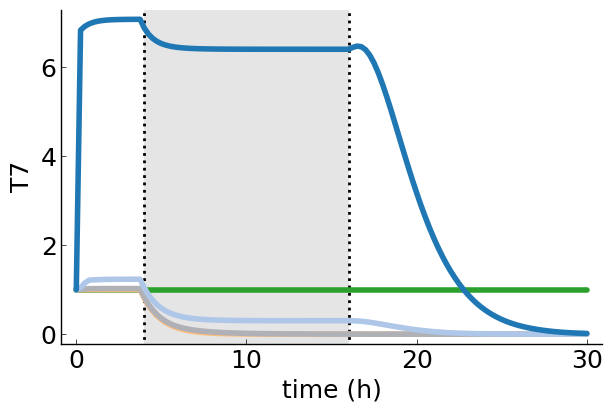

In [24]:
# 1A T7 RNAP
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p4 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX) 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pTPC = [datum for subarr in solU.u for datum in subarr[idx_pT]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pTNC = [datum for subarr in solU.u for datum in subarr[idx_pT]];

plot!(t,pTPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="T7",lw=4);
plot!(t,pTNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pT = [datum for subarr in solU.u for datum in subarr[idx_pT]];
    plot!(t,pT,label=LABELS[j],color=COLOURS[j],lw=4)
end

p4 # Show plot
savefig(PATH_OUT*FN)

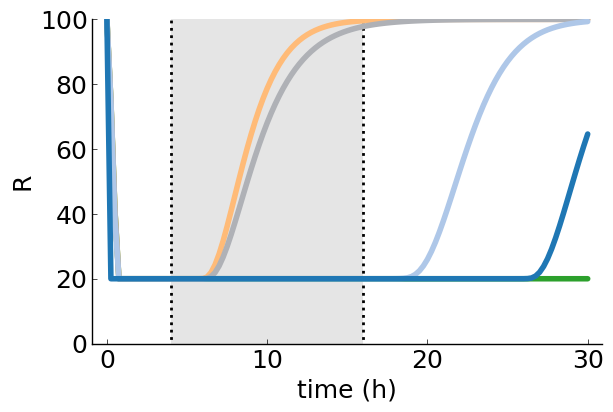

In [36]:
# Resources
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p3 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((0,100));
FN="TS_R.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX)
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
RPC = [datum for subarr in solU.u for datum in subarr[idx_R]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
RNC = [datum for subarr in solU.u for datum in subarr[idx_R]];

plot!(t,RPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="R",lw=4);
plot!(t,RNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    R = [datum for subarr in solU.u for datum in subarr[idx_R]];
    plot!(t,R,label=LABELS[j],color=COLOURS[j],lw=4)
end

p3 # Show plot
savefig(PATH_OUT*FN)

## 1.2 Elucidation of model: resource allocation

In [25]:
function averagerates(solDU)
    
    inds = findall(x -> x.%15==0.0, solDU.t)
    nrinds = size(inds)[1]
    t = solDU.t/60;

    time = [0.0]
    avgTXT = [0.0]
    avgTXG = [0.0]
    avgTLT = [0.0]
    avgTLG = [0.0]

    TXT = [datum for subarr in solDU.saveval for datum in subarr[idx_mT]];
    TXG = [datum for subarr in solDU.saveval for datum in subarr[idx_mG]];
    TLT = [datum for subarr in solDU.saveval for datum in subarr[idx_pT]];
    TLG = [datum for subarr in solDU.saveval for datum in subarr[idx_pG]];
    
    for j in 1:(nrinds-1)
        append!(avgTXT,mean(TXT[inds[j]:inds[j+1]]))
        append!(avgTXG,mean(TXG[inds[j]:inds[j+1]]))
        append!(avgTLT,mean(TLT[inds[j]:inds[j+1]]))
        append!(avgTLG,mean(TLG[inds[j]:inds[j+1]]))
        append!(time,t[inds[j+1]])
    end
    
    return(time,avgTXT,avgTXG,avgTLT,avgTLG)
end

averagerates (generic function with 1 method)

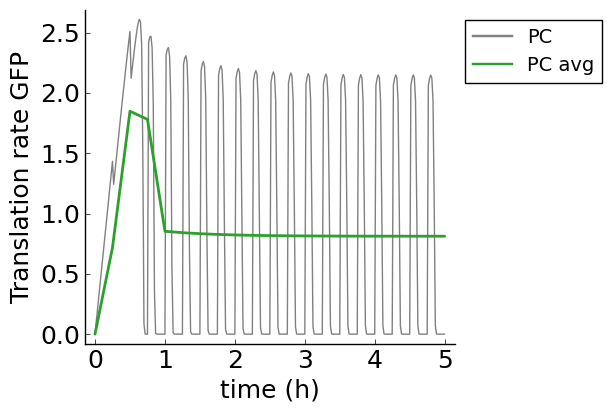

In [30]:
# 1.2A Average vs maximum rates

CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pl1 = plot(grid=:false,legend=:outertopright)
FN="minmaxavg.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:1.0:5*60 # either array or range can be passed
#TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solDU.t/60;
pcTLG = [datum for subarr in solDU.saveval for datum in subarr[idx_pG]];
plot!(t,(pcTLG),label="PC",color=:gray,xaxis="time (h)",
    yaxis="Max translation GFP",lw=1);

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.1*alpha;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.2:5*60 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="PC avg",color="#2ca02c",xaxis="time (h)",
    yaxis="Translation rate GFP",lw=2);

pl1 # Show plot
savefig(PATH_OUT*FN)

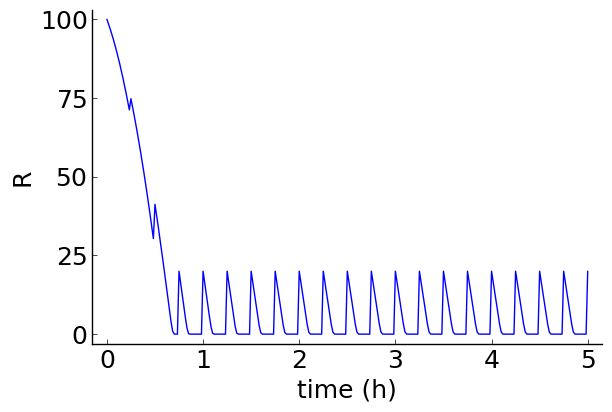

In [32]:
# 1.2A Average vs maximum rates

CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pl2 = plot(grid=:false,legend=:false)#,legend=:outertopright)
FN="minmaxavg_R.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:1.0:5*60 # either array or range can be passed 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pcR = [datum for subarr in solU.u for datum in subarr[idx_R]];
plot!(t,(pcR),label="PC",color="blue",xaxis="time (h)",
    yaxis="R",lw=1);

pl2 # Show plot
savefig(PATH_OUT*FN)

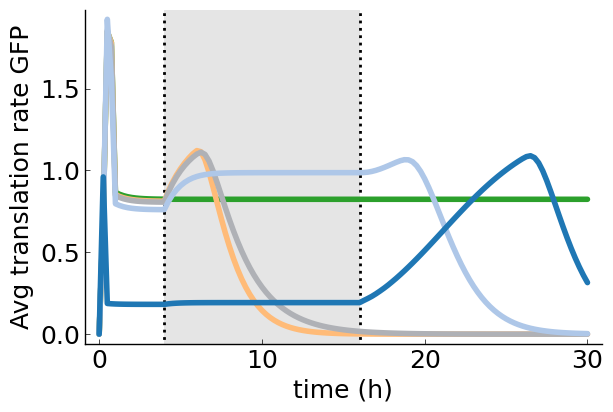

In [33]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p5 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TL_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg translation rate GFP",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLG,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTLG,label=LABELS[j],color=COLOURS[j],lw=4);

end

p5 # Show plot
savefig(PATH_OUT*FN)

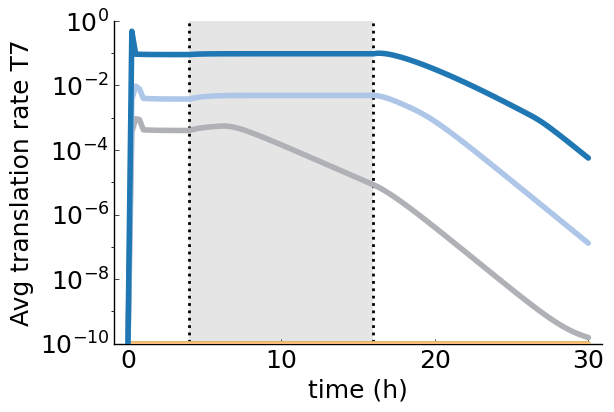

In [60]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p6 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e-0))
FN="rate_TL_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLT.+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg translation rate T7",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTLT.+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTLT.+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

p6 # Show plot
savefig(PATH_OUT*FN)

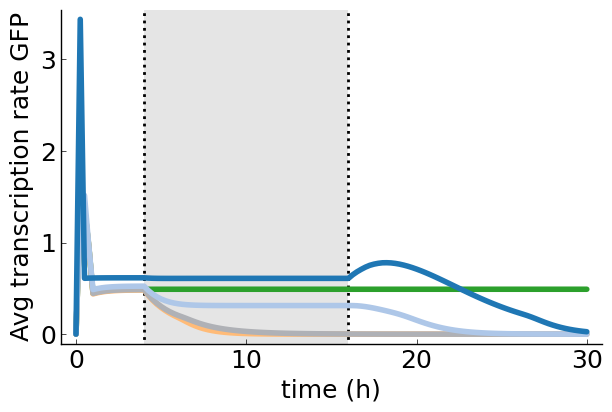

In [62]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p7 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TX_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXG,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg transcription rate GFP",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXG,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTXG,label=LABELS[j],color=COLOURS[j],lw=4);

end

p7 # Show plot
savefig(PATH_OUT*FN)

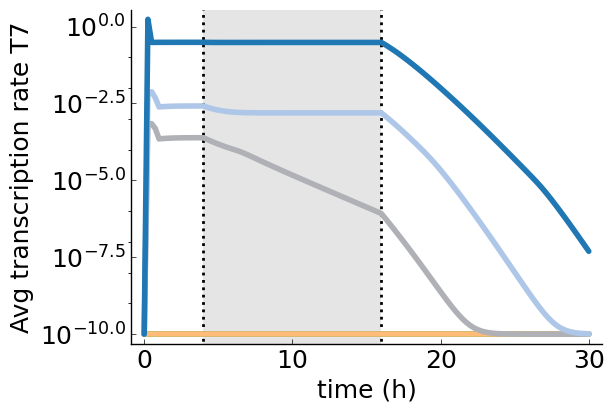

In [58]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p8 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="rate_TX_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXT.+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="Avg transcription rate T7",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,avgTXT.+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,avgTXT.+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

p8 # Show plot
savefig(PATH_OUT*FN)

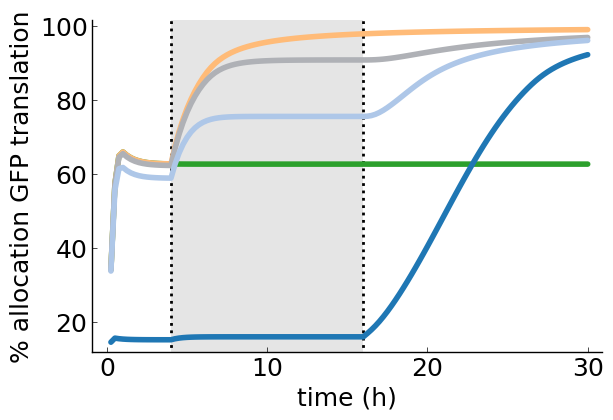

In [39]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation GFP translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll1 # Show plot
savefig(PATH_OUT*FN)

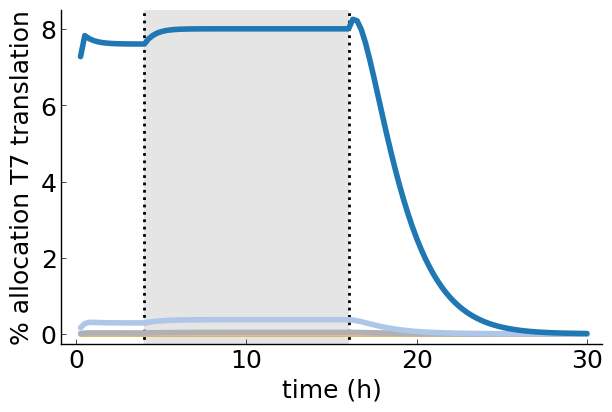

In [71]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll2 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll2 # Show plot
savefig(PATH_OUT*FN)

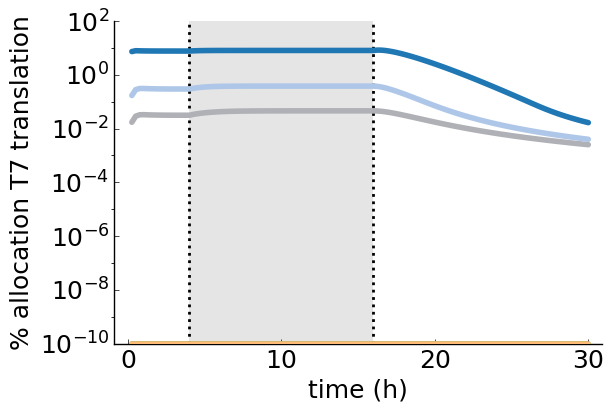

In [72]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll2 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e2))
FN="RA_TL_T7log.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTLT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

pll2 # Show plot
savefig(PATH_OUT*FN)

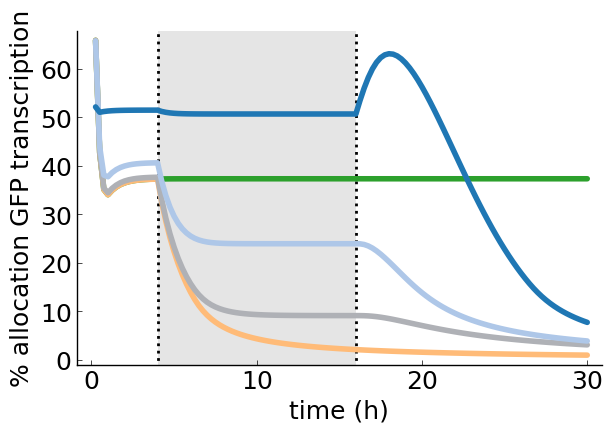

In [41]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll3 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation GFP transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll3 # Show plot
savefig(PATH_OUT*FN)

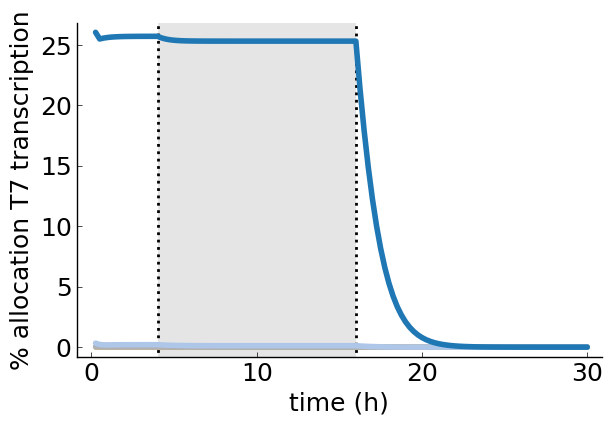

In [44]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll4 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX_T7.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll4 # Show plot
savefig(PATH_OUT*FN)

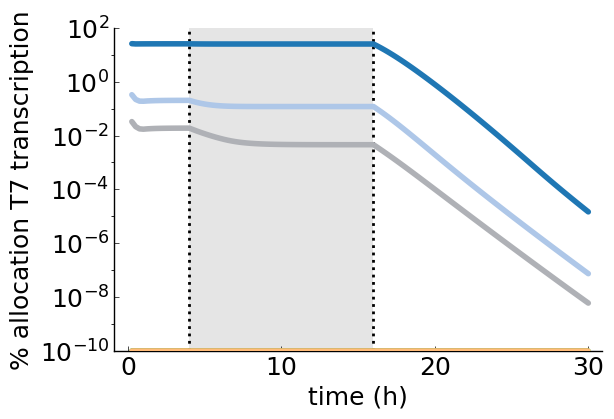

In [73]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll4 = plot(grid=:false,legend=:false,yscale=:log10)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
ylims!((1e-10,1e2))
FN="RA_TX_T7log.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation T7 transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*avgTXT./(avgTXT+avgTXG+avgTLT+avgTLG).+1e-10,label=LABELS[j],color=COLOURS[j],lw=4);

end

pll4 # Show plot
savefig(PATH_OUT*FN)

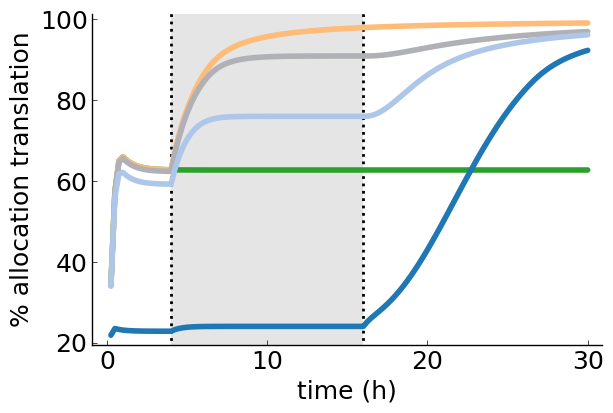

In [45]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll5 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TL.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation translation",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*(avgTLG+avgTLT)./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll5 # Show plot
savefig(PATH_OUT*FN)

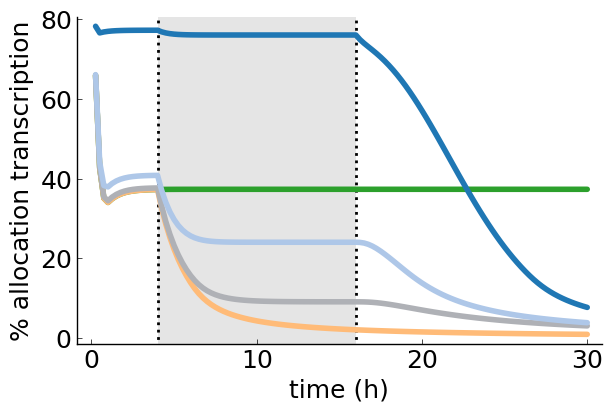

In [46]:
# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
pll6 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="RA_TX.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];


TSAVE = 0.0:0.1:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="PC",color="#2ca02c",xaxis="time (h)",
    yaxis="% allocation transcription",lw=4);


TSAVE = 0.0:0.2:TMAX
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label="NC",color="#ffbb78",lw=4);

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    time,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
    plot!(time,100*(avgTXG+avgTXT)./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[j],color=COLOURS[j],lw=4);

end

pll6 # Show plot
savefig(PATH_OUT*FN)

# 2. Sufficiency of model

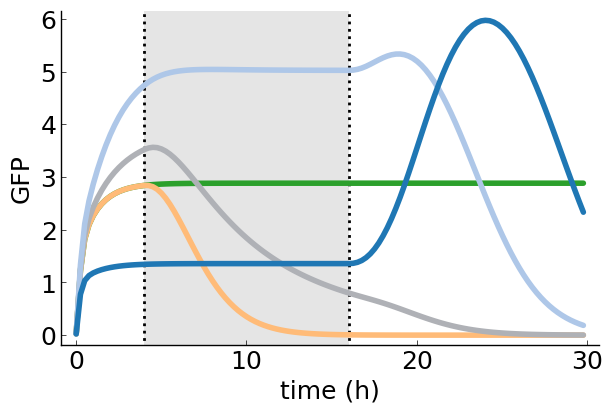

In [12]:
# 1.1 Resource independent, but with TL coupling
CONCS = [0.1,0.6,10]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_RI_.pdf"

# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
TXNC = [datum for subarr in solU.u for datum in subarr[8]];


plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

90.0%┣█████████████████████████████████████▉    ┫ 27/30 [00:01<00:00, 18.4 it/s]

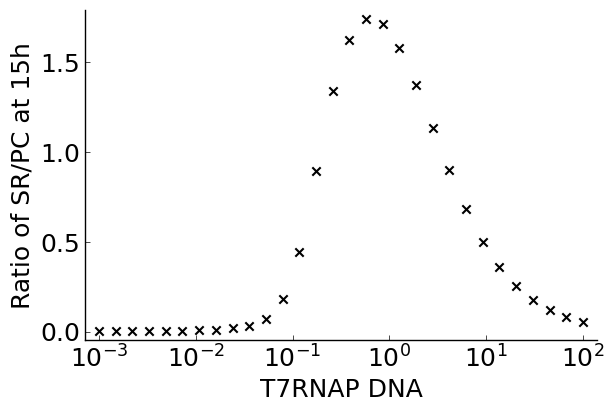

100.0%┣█████████████████████████████████████████┫ 30/30 [00:02<00:00, 17.4 it/s]


In [13]:
# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_RI.pdf"
# Set initial conditions


R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

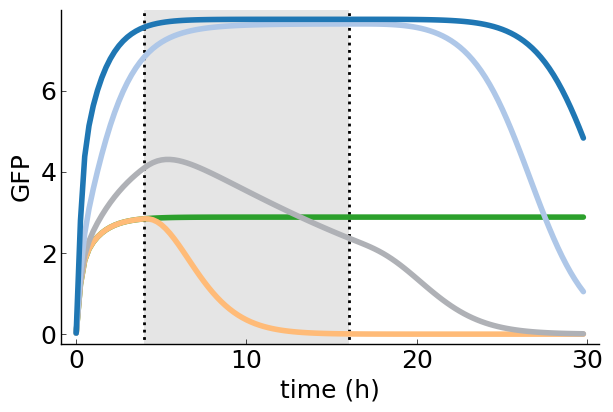

In [48]:
# 1.1 Resource independent, no TL coupling
CONCS = [0.1,0.6,10]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_RInl_.pdf"

# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
TXNC = [datum for subarr in solU.u for datum in subarr[8]];


plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

86.7%┣████████████████████████████████████▍     ┫ 26/30 [00:02<00:00, 14.8 it/s]

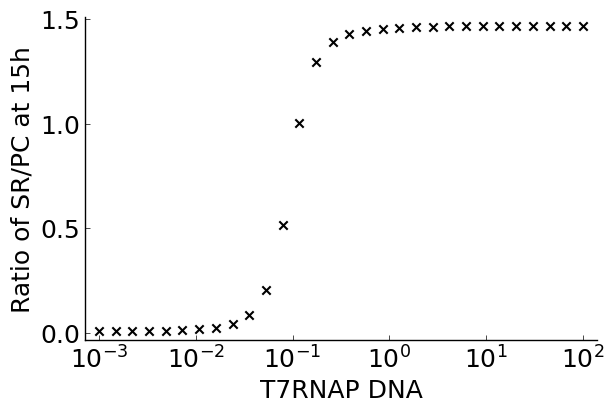

100.0%┣█████████████████████████████████████████┫ 30/30 [00:02<00:00, 15.7 it/s]


In [94]:
# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_RInl.pdf"
# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

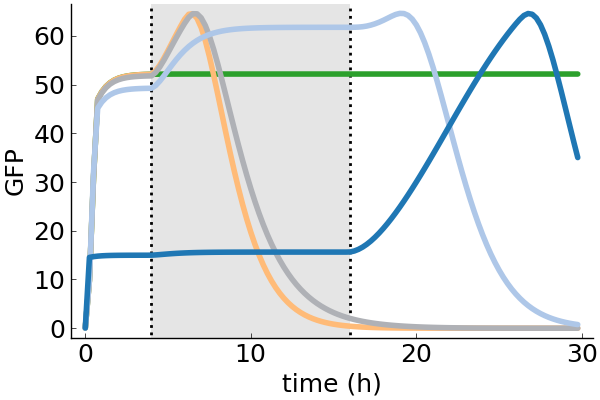

In [49]:
# 1.1 Single resource (original)
CONCS = [0.001,0.01,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
#savefig(PATH_OUT*FN)

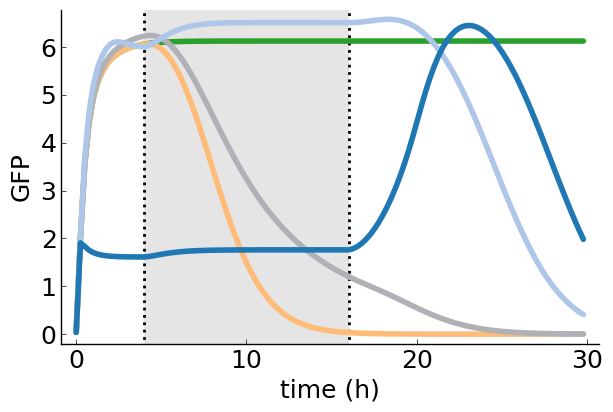

In [50]:
# 1.3 1R+RI model
CONCS = [0.01,0.1,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_1RI.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

96.7%┣█████████████████████████████████████████▋ ┫ 29/30 [00:04<00:00, 6.5 it/s]

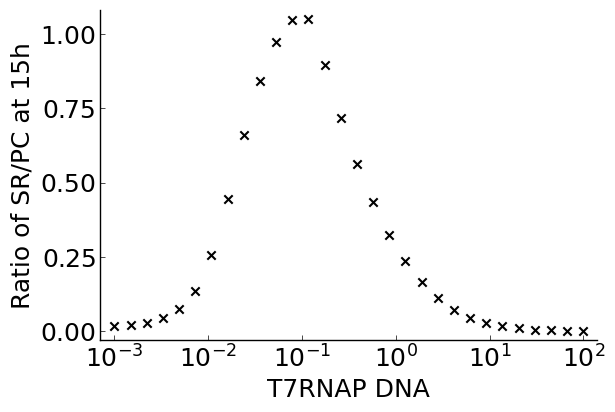

100.0%┣██████████████████████████████████████████┫ 30/30 [00:04<00:00, 6.5 it/s]


In [93]:
# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_1RI.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

# Full model: single resource, resource-independent degradation, saturation of TX and TL

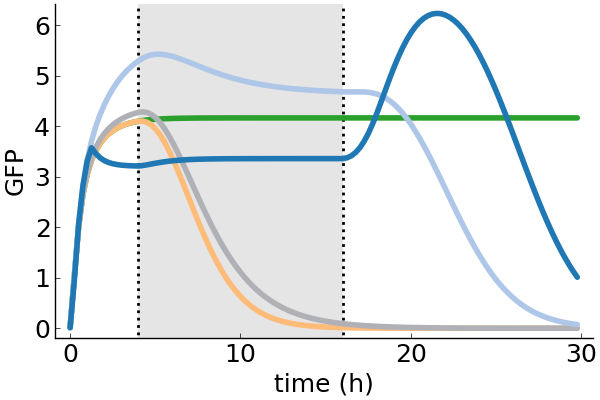

In [5]:
# 1.4 full model

TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

CONCS = [0.01,0.1,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
#FN="TS_GFP_1RI.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
KTX=1;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
#savefig(PATH_OUT*FN)

100.0%┣█████████████████████████████████████████┫ 30/30 [00:03<00:00, 10.9 it/s]


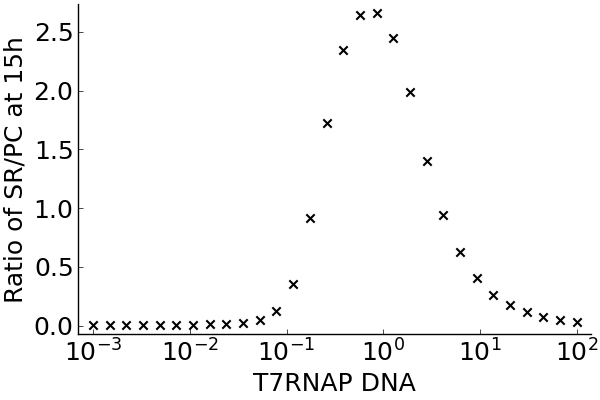

In [6]:
# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
#FN="ratio_GFP_1RI.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
KTX=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
#savefig(PATH_OUT*FN)

100.0%┣█████████████████████████████████████████┫ 30/30 [00:00<00:00, 76.9 it/s]


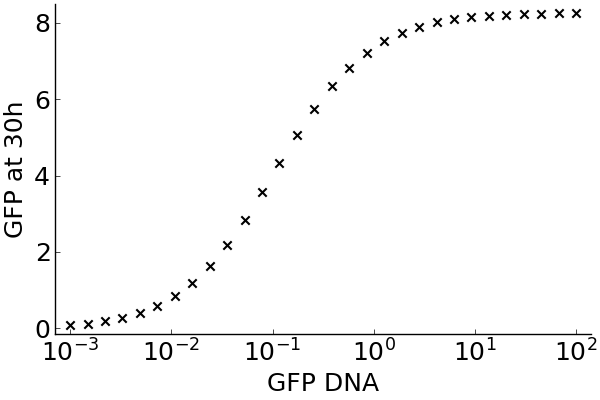

In [14]:
# Batch titrations

# 1.2 Ratio curve
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
pGfin = []
#FN="ratio_GFP_1RI.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=1;
KTX=1;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

TSAVE = collect(0:15:TMAX).+1 

for conc in ProgressBar(CONCS)
    dG0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(pGfin,pG[end])
end

plot(CONCS,pGfin,seriestype=:scatter,xaxis="GFP DNA",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
#savefig(PATH_OUT*FN)

100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 108.4 it/s]


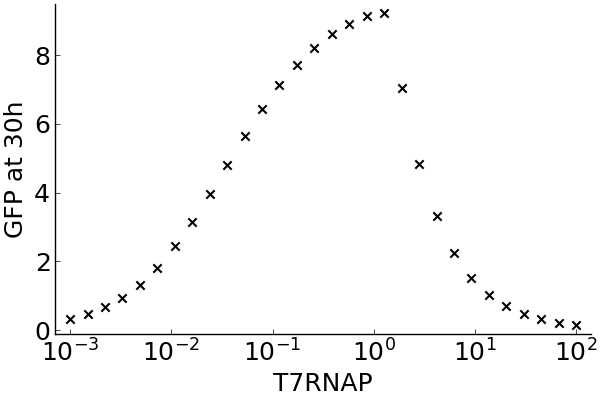

In [81]:
# Batch titrations

# 1.2 Ratio curve
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

# 1.2 Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
pGfin = []
#FN="ratio_GFP_1RI.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=1;
KTX=1;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

TSAVE = collect(0:15:TMAX).+1 

for conc in ProgressBar(CONCS)
    pT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(pGfin,pG[end])
end

plot(CONCS,pGfin,seriestype=:scatter,xaxis="T7RNAP",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
#savefig(PATH_OUT*FN)

# 3. GFP DNA titration

66.7%┣██████████████████████████████               ┫ 2/3 [00:11<00:11, 0.1 it/s]

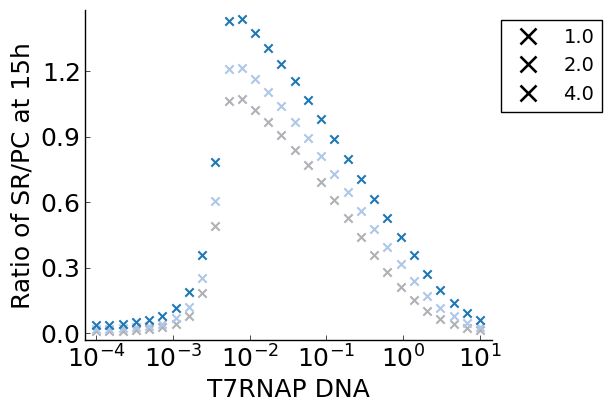

100.0%┣████████████████████████████████████████████┫ 3/3 [00:15<00:00, 0.1 it/s]


In [6]:
# 1.2 Ratio curve

CONCS_GFP = [1.0,2.0,4.0]
colours = ["#afb1b6","#aec7e8","#1f77b4"]

p1 = plot(grid=:false,legend=:outertopright,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10)
FN="GFPtitration_ratio.pdf"


for i in ProgressBar((1:size(CONCS_GFP)[1]))
    CONCS = exp10.(range(-4, stop=1, length=30))
    ratio_SRPC = []

    # Set initial conditions

    R0=100.0;
    dT0=0.0;
    dG0=CONCS_GFP[i];
    mT0=0.0;
    mG0=0.0;
    pT0=1.0;
    pG0=0.0;

    alpha=0.7;
    beta=0.1*alpha;
    K=1.0;
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];

    TSAVE = collect(0:15:TMAX).+1 
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
    t = solU.t/60;
    pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    # Index at 15h
    idx = findall(x -> x == 901,TSAVE)

    for conc in CONCS
        dT0=conc
        u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
        params = [alpha,beta,K];
        solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
        pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
        append!(ratio_SRPC,pG[idx]/pGPC[idx])
    end
    
    plot!(CONCS,ratio_SRPC,seriestype=:scatter,
    markershape=:x,label=CONCS_GFP[i],markersize=6,color=colours[i])

end

p1 # Show plot
savefig(PATH_OUT*FN)

66.7%┣██████████████████████████████               ┫ 2/3 [00:01<00:01, 1.2 it/s]

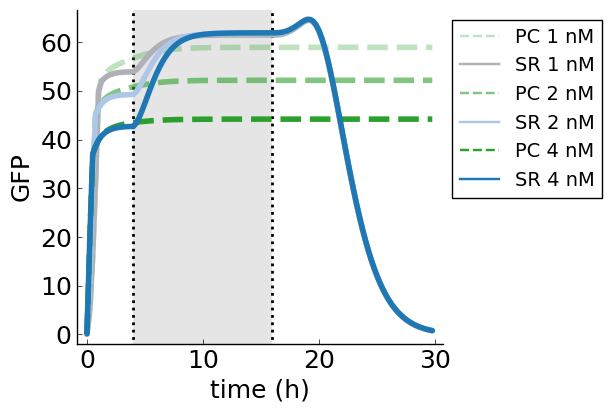

100.0%┣████████████████████████████████████████████┫ 3/3 [00:01<00:00, 1.7 it/s]


In [20]:
CONCS_GFP = [1.0,2.0,4.0]
colours = ["#afb1b6","#aec7e8","#1f77b4"]
alphas = [0.3,0.6,1.0]
labels = [" 1 nM", " 2 nM", " 4 nM"]


p = plot(grid=:false,legend=:outertopright,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4)
vspan!([4,16],fill=:black,alpha=:0.1,label=""); vline!([4,16],color=:black,linestyle=:dot,linewidth=2,label="");
FN="GFPtitration_TS.pdf"


for i in ProgressBar((1:size(CONCS_GFP)[1]))
    CONCS = exp10.(range(-4, stop=1, length=30))
    ratio_SRPC = []

    # Set initial conditions

    R0=100.0;
    dT0=1e-2;
    dG0=CONCS_GFP[i];
    mT0=0.0;
    mG0=0.0;
    pT0=1.0;
    pG0=0.0;

    alpha=0.7;
    beta=0.1*alpha;
    K=1.0;
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];

    TSAVE = collect(0:15:TMAX).+1 
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
    t = solU.t/60;
    pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    t = solU.t/60;
    pGSR = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    
    plot!(t,pGPC,label="PC"*labels[i],lw=4,color="#2ca02c",alpha=alphas[i],line=(:dash,4))
    plot!(t,pGSR,label="SR"*labels[i],lw=4,color=colours[i])
end
p # Show plot
savefig(PATH_OUT*FN)

# Batch reaction T7RNAP titration

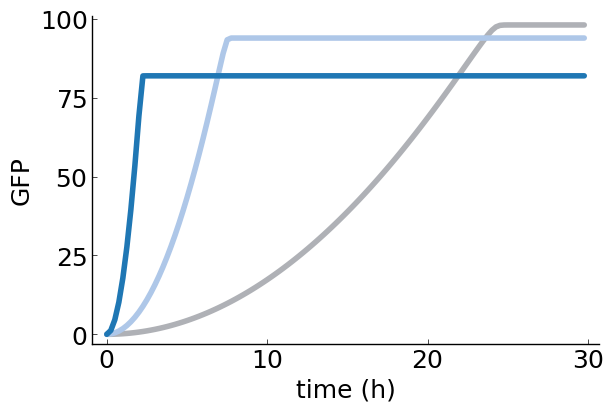

In [11]:
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

# 1.1 Time series
CONCS = [0.001,0.01,0.1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false,xaxis="time (h)",yaxis="GFP")#,legend=:outertopright)
FN="TS_batchGFP.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = collect(0:15:TMAX).+1 

for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

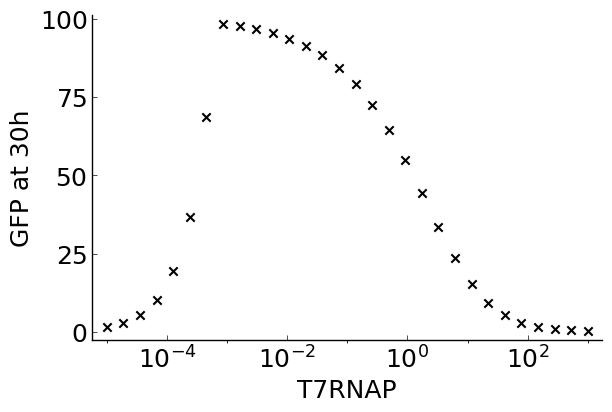

In [34]:
# 1.1 Time series
CONCS = exp10.(range(-5, stop=3, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
FN="TS_batchGFP_titration.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = collect(0:15:TMAX).+1 

pGfin = []
for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end

p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="T7RNAP",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)

p1 # Show plot
savefig(PATH_OUT*FN)

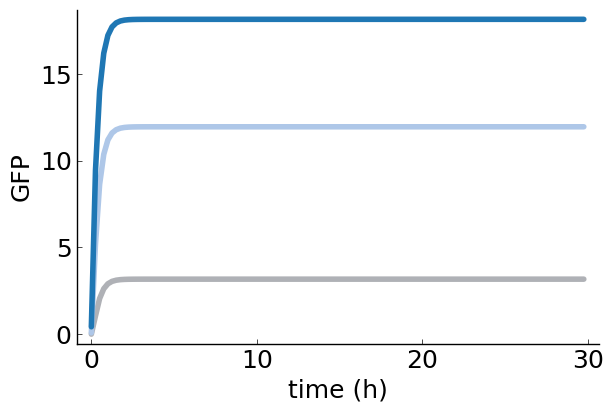

In [14]:
# 1.1 Resource independent, but with TL coupling
CONCS = [0.1,1,10]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false,xaxis="time (h)",yaxis="GFP")#,legend=:outertopright)
FN="TS_batchGFP_RI.pdf"

# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.05;
lamb2=0.05;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 

for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

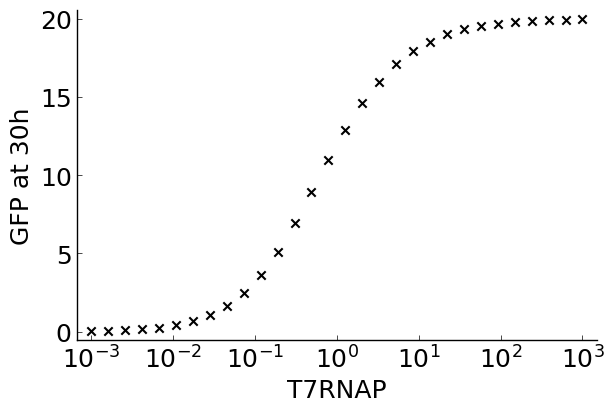

In [31]:
# 1.1 Time series
CONCS = exp10.(range(-3, stop=3, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
FN="TS_batchGFP_RItitration.pdf"

# Set initial conditions
pGfin=[]
R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.05;
lamb2=0.05;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 

for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end


p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="T7RNAP",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)

p1 # Show plot
savefig(PATH_OUT*FN)

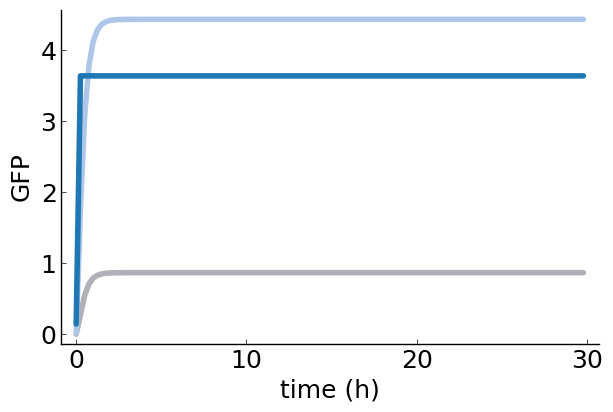

In [15]:
# 1.1 Time series
CONCS = [0.01,0.1,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
p1 = plot(grid=:false,legend=:false,xaxis="time (h)",yaxis="GFP")#,legend=:outertopright)
FN="TS_batchGFP_1RI.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;

u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 

for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

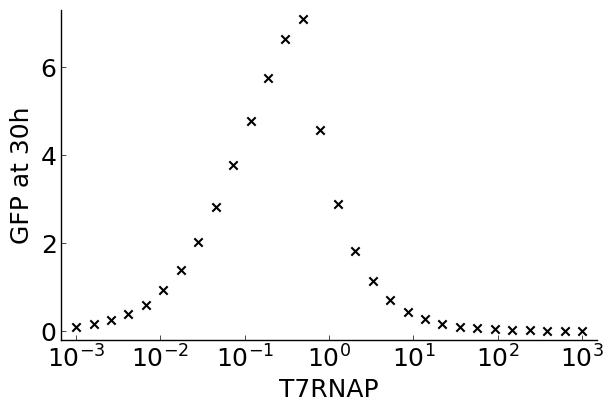

In [33]:
# 1.1 Time series
CONCS = exp10.(range(-3, stop=3, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
FN="TS_batchGFP_1RItitration.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;

u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 
pGfin=[]
for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end
p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="T7RNAP",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)

p1 # Show plot
savefig(PATH_OUT*FN)

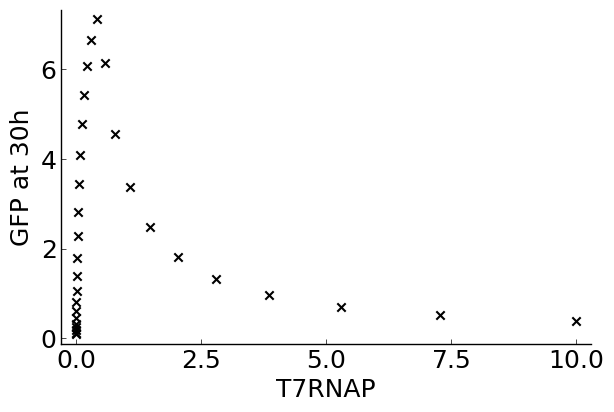

In [37]:
# 1.1 Time series
CONCS = exp10.(range(-3, stop=1, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
FN="TS_batchGFP_1RItitration_lin.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;

u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 
pGfin=[]
for j in (1:size(CONCS)[1])
    pT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end
p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="T7RNAP",yaxis="GFP at 30h",
    markershape=:x,label="",color=:black,markersize=6,grid=:false)

p1 # Show plot
savefig(PATH_OUT*FN)

# Figures resource allocation/loading

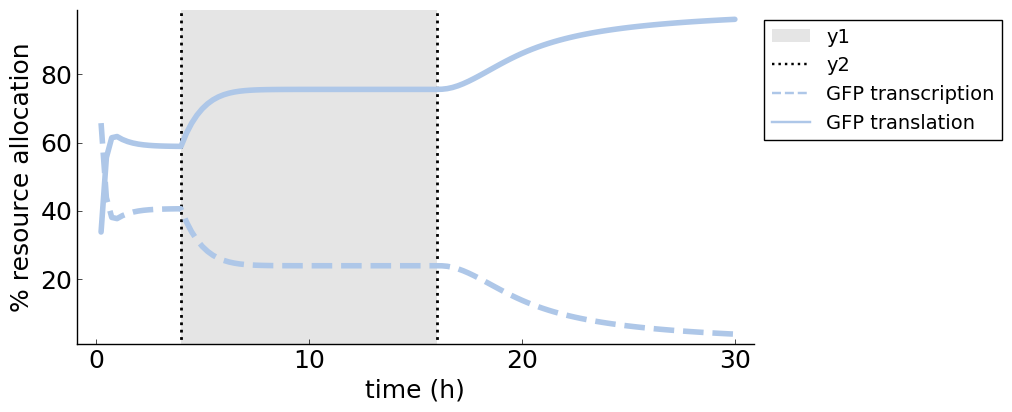

In [22]:
function averagerates(solDU)
    
    inds = findall(x -> x.%15==0.0, solDU.t)
    nrinds = size(inds)[1]
    t = solDU.t/60;

    time = [0.0]
    avgTXT = [0.0]
    avgTXG = [0.0]
    avgTLT = [0.0]
    avgTLG = [0.0]

    TXT = [datum for subarr in solDU.saveval for datum in subarr[idx_mT]];
    TXG = [datum for subarr in solDU.saveval for datum in subarr[idx_mG]];
    TLT = [datum for subarr in solDU.saveval for datum in subarr[idx_pT]];
    TLG = [datum for subarr in solDU.saveval for datum in subarr[idx_pG]];
    
    for j in 1:(nrinds-1)
        append!(avgTXT,mean(TXT[inds[j]:inds[j+1]]))
        append!(avgTXG,mean(TXG[inds[j]:inds[j+1]]))
        append!(avgTLT,mean(TLT[inds[j]:inds[j+1]]))
        append!(avgTLG,mean(TLG[inds[j]:inds[j+1]]))
        append!(time,t[inds[j+1]])
    end
    
    return(time,avgTXT,avgTXG,avgTLT,avgTLG)
end

# 1.3 Resource allocation timeseries

# 1.1 Time series
CONCS = [0.01]
LABELS = ["GFP transcription","GFP translation"]
COLOURS = ["#aec7e8"]
PATH_OUT = "./output/"
pll3 = plot(grid=:false,legend=:outertopright,xaxis="time (h)",
    yaxis="% resource allocation")
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="fig_RA.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = 0.0:0.1:TMAX


dT0=CONCS[1]
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
time1,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time1,100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[1],color=COLOURS[1],lw=4,linestyle=:dash,size=(1000,400));


dT0=CONCS[1]
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
time2,avgTXT,avgTXG,avgTLT,avgTLG = averagerates(solDU);
plot!(time2,100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG),label=LABELS[2],color=COLOURS[1],lw=4);


pll3 # Show plot
#savefig(PATH_OUT*FN)


FILE_OUT_t1 = "fig_RA_time1.csv"
FILE_OUT_t2 = "fig_RA_time2.csv"
FILE_OUT_U1 = "fig_RA_tx.csv"
FILE_OUT_U2 = "fig_RA_tl.csv"

writedlm(string(PATH_OUT,FILE_OUT_t1),  time1, ',')
writedlm(string(PATH_OUT,FILE_OUT_U1),  100*avgTXG./(avgTXT+avgTXG+avgTLT+avgTLG), ',')
writedlm(string(PATH_OUT,FILE_OUT_t2),  time2, ',')
writedlm(string(PATH_OUT,FILE_OUT_U2),  100*avgTLG./(avgTXT+avgTXG+avgTLT+avgTLG), ',')


96.7%┣█████████████████████████████████████████▋ ┫ 29/30 [00:04<00:00, 6.8 it/s]

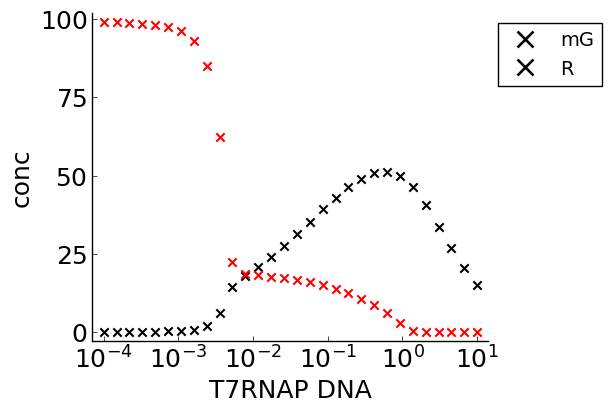

100.0%┣██████████████████████████████████████████┫ 30/30 [00:04<00:00, 6.8 it/s]


In [23]:
# 1.2 Ratio curve
CONCS = exp10.(range(-4, stop=1, length=30))
ms = []
Rs = []
FN="fig_load.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    m = [datum for subarr in solU.u for datum in subarr[idx_mG]];
    R = [datum for subarr in solU.u for datum in subarr[idx_R]];
    append!(ms,m[idx])
    append!(Rs,R[idx])
end

plot(CONCS,ms,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="conc",
    xscale=:log10,markershape=:x,label="mG",color=:black,markersize=6,grid=:false,legend=:outertopright)
plot!(CONCS,Rs,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="conc",
    xscale=:log10,markershape=:x,label="R",color=:red,markersize=6,grid=:false)
#savefig(PATH_OUT*FN)


FILE_OUT_c = "fig_RA_conc.csv"
FILE_OUT_X1 = "fig_RA_X1.csv"
FILE_OUT_X2 = "fig_RA_X2.csv"

writedlm(string(PATH_OUT,FILE_OUT_c),  CONCS, ',')
writedlm(string(PATH_OUT,FILE_OUT_X1),  ms, ',')
writedlm(string(PATH_OUT,FILE_OUT_X2),  Rs, ',')


# GFP titration saturation

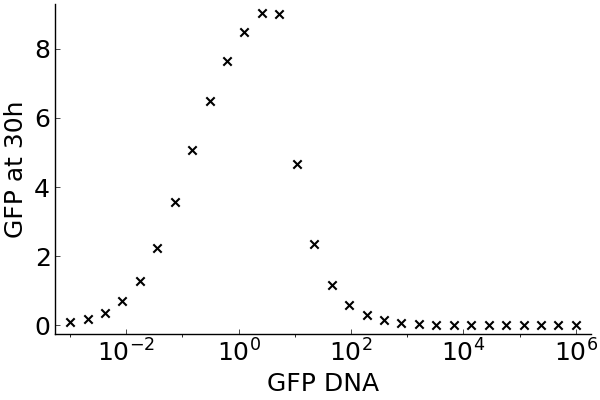

In [38]:
# 1.2 Ratio curve
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages



# Set initial conditions
# 1.1 Time series
CONCS = exp10.(range(-3, stop=6, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=1;
K=1;

u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 
pGfin=[]
for j in (1:size(CONCS)[1])
    dG0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end
p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="GFP DNA",yaxis="GFP at 30h",
    markershape=:x,label="",color=:black,markersize=6,grid=:false,xscale=:log10)

p1 # Show plot
#savefig(PATH_OUT*FN)

100.0%┣████████████████████████████████████████┫ 30/30 [00:00<00:00, 105.1 it/s]


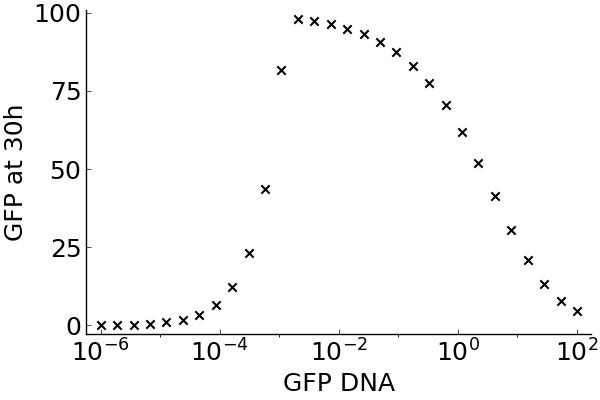

In [33]:
# 1.2 Ratio curve
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages
pGfin=[]

# Set initial conditions
# 1.1 Time series
CONCS = exp10.(range(-6, stop=2, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;

alpha=0.7;
beta=0.07;
K=1.0;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
params = [alpha,beta,K];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dG0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0];
    params = [alpha,beta,K];
    solU,solDU=solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end

plot(CONCS,pGfin,seriestype=:scatter,xaxis="GFP DNA",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)

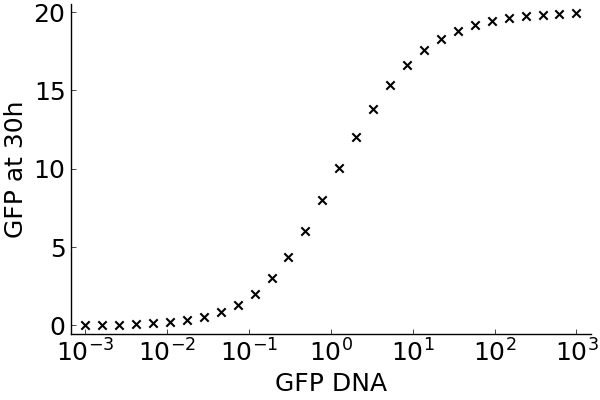

In [27]:
# 1.2 Ratio curve
# Make sure to reset params before running anything else
TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.0;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages
pGfin=[]


# 1.1 Time series
CONCS = exp10.(range(-3, stop=3, length=30))
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
PATH_OUT = "./output/"
FN="TS_batchGFP_RItitration.pdf"

# Set initial conditions
pGfin=[]
R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.05;
lamb2=0.05;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 

for j in (1:size(CONCS)[1])
    dG0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    t = solU.t/60
    push!(pGfin,last(pG))
end


p1=plot(CONCS,pGfin,seriestype=:scatter,xaxis="GFP DNA",yaxis="GFP at 30h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)

p1 # Show plot

In [3]:
# Yield robustness